In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import f1_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
#Loading the iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

In [3]:
# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

In [4]:
# Scale data to have mean 0 and variance 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=3)

n_features = X.shape[1]
n_classes = Y.shape[1]

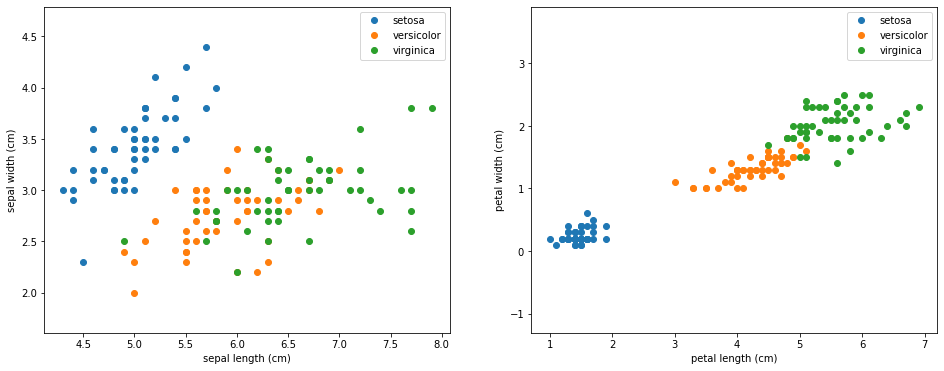

In [6]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

In [7]:
initializer0 = keras.initializers.RandomUniform(minval=-0.003, maxval=0)
initializer1 = keras.initializers.RandomUniform(minval=-0.003, maxval=0)

class Adaact(keras.layers.Layer):
    def __init__(self):
        super(Adaact, self).__init__()
        self.k0 = self.add_weight(name='k0', shape=(), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape=(), initializer=initializer1, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1)

In [8]:
# Create the model with one hidden layer
model = Sequential()
model.add(layers.Dense(25, input_dim=n_features))
adaact = Adaact()
model.add(adaact)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                125       
                                                                 
 adaact (Adaact)             (None, 25)                2         
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"])

history=model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 26ms/step - loss: 1.0988 - accuracy: 0.3438 - val_loss: 1.0988 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 1.0954 - accuracy: 0.5000 - val_loss: 1.0924 - val_accuracy: 0.5417
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 1.0776 - accuracy: 0.7396 - val_loss: 1.0679 - val_accuracy: 0.8750
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 1.0357 - accuracy: 0.8333 - val_loss: 1.0155 - val_accuracy: 0.9583
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.9548 - accuracy: 0.8854 - val_loss: 0.9327 - val_accuracy: 0.9583
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.8465 - accuracy: 0.8333 - val_loss: 0.8290 - val_accuracy: 0.9583
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.7348 - accuracy: 0.8229 - val_loss: 0.7202 - val_accuracy: 0.9167
Epoch 8/100


In [11]:
print("AF coefficients (weights) {}".format(adaact.get_weights()))

AF coefficients (weights) [0.3307859, 0.59671104]


In [12]:
# Obtain test loss and test accuracy
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05791618674993515
Test accuracy: 0.9666666388511658


In [13]:
# Obtain train loss and train accuracy
score = model.evaluate(X_train, Y_train, verbose=0)
print("train loss:", score[0])
print("train accuracy:", score[1])

train loss: 0.06885997205972672
train accuracy: 0.9750000238418579


In [14]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

1/1 [==============================] - 0s 165ms/step


In [15]:
# Compute the F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print("f1 score is {}".format(f1))

f1 score is 0.9665831244778613


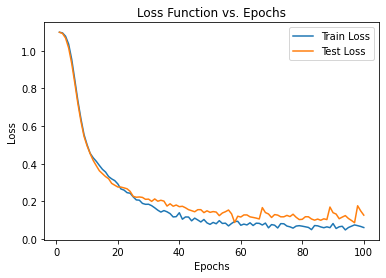

In [16]:
# Plot the loss function vs. epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs')
plt.legend()
plt.show()